In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, MultiHeadAttention
from tensorflow.keras.models import Model
import akshare as ak
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
plt.rcParams['font.size'] = 12

In [5]:
# --------------------------1. 调试和修复数据获取问题--------------------------
print("正在获取A股数据...")

# 方法1：尝试不同的股票代码和参数
stock_codes_to_try = ["600519", "000001", "000858", "300750"]  # 茅台, 平安, 五粮液, 宁德时代

for stock_code in stock_codes_to_try:
    print(f"尝试获取股票 {stock_code} 的数据...")

    try:
        # 尝试获取数据（调整参数）
        df = ak.stock_zh_a_hist(
            symbol=stock_code,
            period="daily",
            start_date="20200101",  # 调整日期格式
            end_date="20251105",
            adjust="qfq"
        )

        if df is not None and len(df) > 0:
            print(f"成功获取股票 {stock_code} 的数据，共 {len(df)} 行")
            break
        else:
            print(f"股票 {stock_code} 返回空数据，尝试下一个...")

    except Exception as e:
        print(f"获取股票 {stock_code} 时出错: {e}")
        continue

# 如果所有尝试都失败，使用备用数据
if 'df' not in locals() or df is None or len(df) == 0:
    print("所有股票代码都失败，创建示例数据...")
    # 创建示例数据
    dates = pd.date_range(start="2020-01-01", end="2025-11-5", freq='D')
    np.random.seed(42)

    # 模拟股价数据
    price = 100 + np.cumsum(np.random.randn(len(dates)) * 0.5)
    df = pd.DataFrame({
        '日期': dates,
        '开盘': price + np.random.randn(len(dates)) * 2,
        '最高': price + np.random.randn(len(dates)) * 3 + 2,
        '最低': price + np.random.randn(len(dates)) * 3 - 2,
        '收盘': price,
        '成交量': np.random.randint(1000000, 10000000, len(dates))
    })

    print("使用模拟数据进行演示")

正在获取A股数据...
尝试获取股票 600519 的数据...
成功获取股票 600519 的数据，共 1415 行


In [6]:
df

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2020-01-02,600519,920.72,922.72,937.78,908.72,148099,1.669684e+10,2.98,-5.43,-53.00,1.18
1,2020-01-03,600519,909.72,871.28,909.72,869.62,130319,1.426638e+10,4.35,-5.57,-51.44,1.04
2,2020-01-06,600519,863.58,870.71,885.62,860.02,63415,6.853918e+09,2.94,-0.07,-0.57,0.50
3,2020-01-07,600519,870.22,887.25,891.72,869.12,47854,5.220697e+09,2.60,1.90,16.54,0.38
4,2020-01-08,600519,877.77,880.86,888.22,875.30,25008,2.720372e+09,1.46,-0.72,-6.39,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...
1410,2025-10-30,600519,1421.81,1426.74,1436.63,1421.81,47456,6.768821e+09,1.03,-0.36,-5.16,0.38
1411,2025-10-31,600519,1422.00,1430.01,1435.98,1420.11,35694,5.109624e+09,1.11,0.23,3.27,0.29
1412,2025-11-03,600519,1431.00,1435.00,1448.00,1420.10,34548,4.945311e+09,1.95,0.35,4.99,0.28
1413,2025-11-04,600519,1435.10,1429.00,1435.78,1423.78,26566,3.793893e+09,0.84,-0.42,-6.00,0.21


In [7]:

# --------------------------2. 数据预处理--------------------------
print(f"数据形状: {df.shape}")
print("数据前5行:")
print(df.head())

# 确保日期列处理正确
if '日期' in df.columns:
    df["日期"] = pd.to_datetime(df["日期"])
    df = df.sort_values("日期")  # 按日期排序
    df.set_index("日期", inplace=True)
else:
    # 如果日期已经是索引
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

# 选择特征
features = ["开盘", "最高", "最低", "收盘", "成交量"]
# 检查列名是否匹配
available_features = [col for col in features if col in df.columns]
if len(available_features) < len(features):
    print(f"警告: 部分特征列不存在，使用可用特征: {available_features}")
    features = available_features

data = df[features].dropna()
print(f"最终数据形状: {data.shape}")

# --------------------------3. 数据归一化--------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# --------------------------4. 划分训练集和测试集--------------------------
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
time_window = 30

# 找到收盘价的索引
close_idx = features.index("收盘") if "收盘" in features else 0
print(f"收盘价在特征中的索引: {close_idx}")

def create_sequences(data, time_window, target_idx):
    X, y = [], []
    for i in range(time_window, len(data)):
        X.append(data[i - time_window:i])
        y.append(data[i, target_idx])
    return np.array(X), np.array(y)

train_X, train_y = create_sequences(train_data, time_window, close_idx)
test_X, test_y = create_sequences(test_data, time_window, close_idx)

print(f"训练集形状: X {train_X.shape}, y {train_y.shape}")
print(f"测试集形状: X {test_X.shape}, y {test_y.shape}")

数据形状: (1415, 12)
数据前5行:
           日期    股票代码      开盘      收盘      最高      最低     成交量           成交额  \
0  2020-01-02  600519  920.72  922.72  937.78  908.72  148099  1.669684e+10   
1  2020-01-03  600519  909.72  871.28  909.72  869.62  130319  1.426638e+10   
2  2020-01-06  600519  863.58  870.71  885.62  860.02   63415  6.853918e+09   
3  2020-01-07  600519  870.22  887.25  891.72  869.12   47854  5.220697e+09   
4  2020-01-08  600519  877.77  880.86  888.22  875.30   25008  2.720372e+09   

     振幅   涨跌幅    涨跌额   换手率  
0  2.98 -5.43 -53.00  1.18  
1  4.35 -5.57 -51.44  1.04  
2  2.94 -0.07  -0.57  0.50  
3  2.60  1.90  16.54  0.38  
4  1.46 -0.72  -6.39  0.20  
最终数据形状: (1415, 5)
收盘价在特征中的索引: 3
训练集形状: X (1102, 30, 5), y (1102,)
测试集形状: X (253, 30, 5), y (253,)


In [13]:
data

,开盘,最高,最低,收盘,成交量
日期,,,,,
2020-01-02,920.72,937.78,908.72,922.72,148099
2020-01-03,909.72,909.72,869.62,871.28,130319
2020-01-06,863.58,885.62,860.02,870.71,63415
2020-01-07,870.22,891.72,869.12,887.25,47854
2020-01-08,877.77,888.22,875.30,880.86,25008
...,...,...,...,...,...
2025-10-30,1421.81,1436.63,1421.81,1426.74,47456
2025-10-31,1422.00,1435.98,1420.11,1430.01,35694
2025-11-03,1431.00,1448.00,1420.10,1435.00,34548


In [8]:

# --------------------------5. 构建和训练模型--------------------------
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(50, return_sequences=True, activation='tanh')(inputs)
    attention_out = MultiHeadAttention(num_heads=4, key_dim=32)(lstm_out, lstm_out)  # 减小复杂度
    combined = lstm_out + attention_out
    last_step = combined[:, -1, :]
    output = Dense(1, activation='linear')(last_step)
    return Model(inputs=inputs, outputs=output)

model = build_lstm_attention_model((time_window, len(features)))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 30, 50)    │     11,200 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 50)    │     26,034 │ lstm_1[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 50)    │          0 │ lstm_1[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 50)        │          0 │ add_1[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         51 │ get_item_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,285 (145.64 KB)

 Trainable params: 37,285 (145.64 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:

# 训练模型（减少epochs以快速测试）
history = model.fit(
    train_X, train_y,
    epochs=200,  # 减少epochs
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False
)

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054 - val_loss: 7.6048e-04
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 7.1514e-04
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 5.0542e-04
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 4.7111e-04
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 4.5262e-04
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 4.4016e-04
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 4.3497e-04
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 4.4025e-04
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 4.4135e-04
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 4.2622e-04
Epoch 12/200
28/28 ━━━

In [10]:

# --------------------------6. 预测和反归一化--------------------------
# 进行预测
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

def inverse_transform_pred(y_pred, scaler, features, target_idx):
    y_reshaped = np.zeros(shape=(len(y_pred), len(features)))
    y_reshaped[:, target_idx] = y_pred.flatten()
    return scaler.inverse_transform(y_reshaped)[:, target_idx]

train_pred_inv = inverse_transform_pred(train_pred, scaler, features, close_idx)
test_pred_inv = inverse_transform_pred(test_pred, scaler, features, close_idx)
train_y_true = inverse_transform_pred(train_y.reshape(-1, 1), scaler, features, close_idx)
test_y_true = inverse_transform_pred(test_y.reshape(-1, 1), scaler, features, close_idx)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


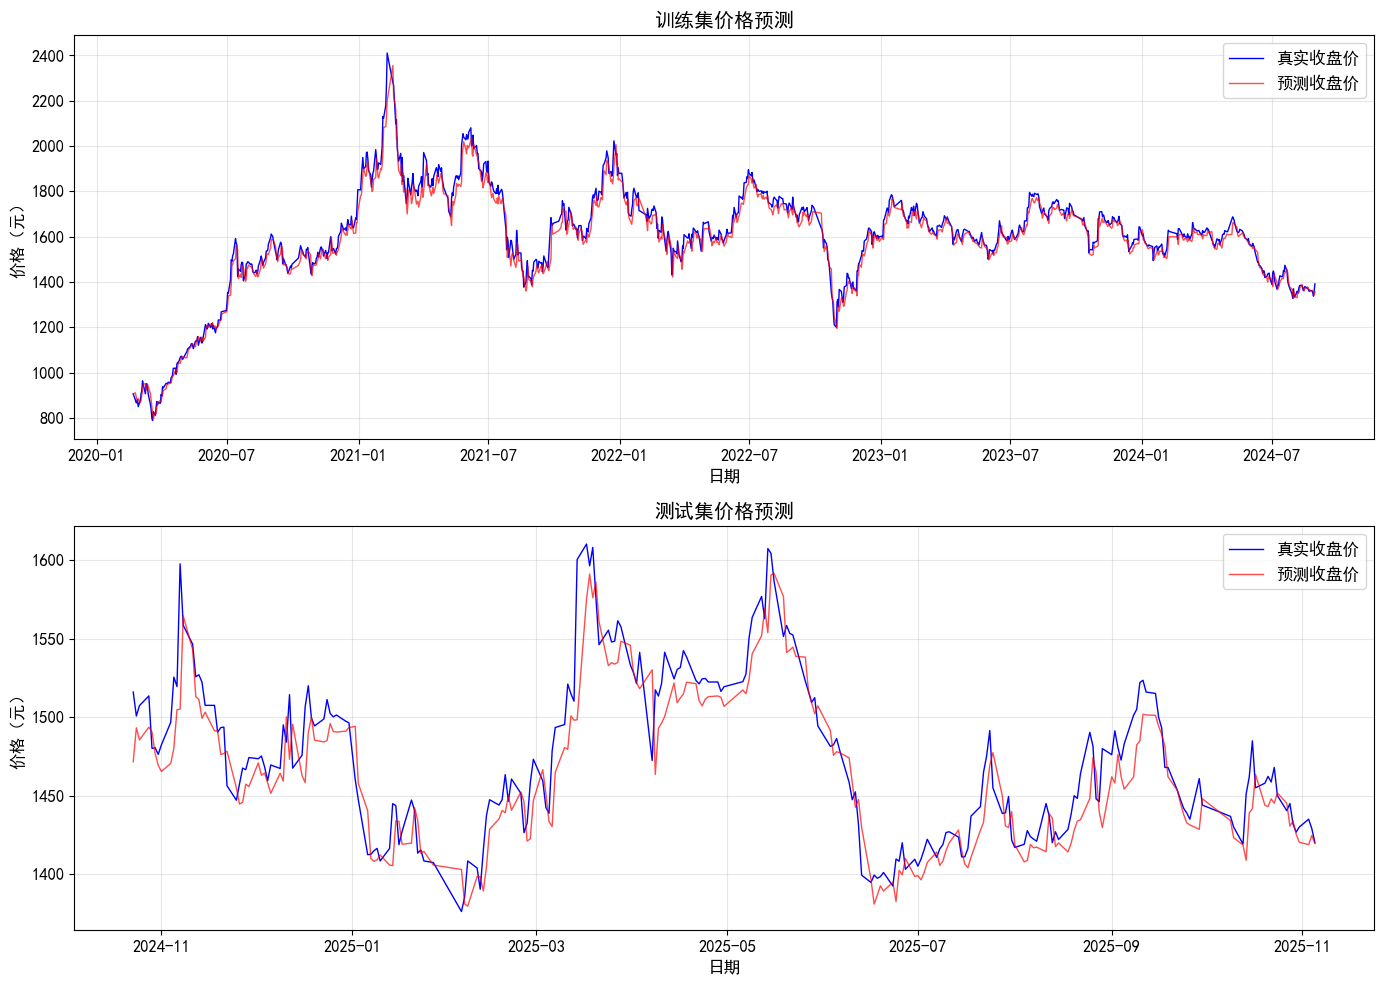

In [11]:

# --------------------------7. 可视化结果--------------------------
# 创建对应的日期索引
train_dates = data.index[time_window:train_size]
test_dates = data.index[train_size + time_window:]

plt.figure(figsize=(14, 10))

# 训练集结果
plt.subplot(2, 1, 1)
plt.plot(train_dates, train_y_true, label='真实收盘价', color='blue', linewidth=1)
plt.plot(train_dates, train_pred_inv, label='预测收盘价', color='red', linewidth=1, alpha=0.7)
plt.title(f'训练集价格预测')
plt.xlabel('日期')
plt.ylabel('价格（元）')
plt.legend()
plt.grid(True, alpha=0.3)

# 测试集结果
plt.subplot(2, 1, 2)
plt.plot(test_dates, test_y_true, label='真实收盘价', color='blue', linewidth=1)
plt.plot(test_dates, test_pred_inv, label='预测收盘价', color='red', linewidth=1, alpha=0.7)
plt.title(f'测试集价格预测')
plt.xlabel('日期')
plt.ylabel('价格（元）')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


模型性能评估:
训练集 - MAE: 29.1633, RMSE: 39.3946, R²: 0.9702
测试集 - MAE: 15.7780, RMSE: 21.0561, R²: 0.8286


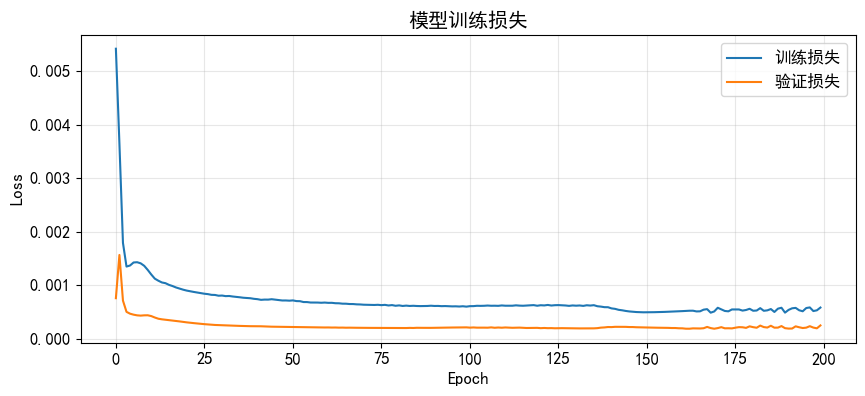

In [12]:

# 计算评估指标
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)
    return mae, rmse, r2

train_mae, train_rmse, train_r2 = calculate_metrics(train_y_true, train_pred_inv)
test_mae, test_rmse, test_r2 = calculate_metrics(test_y_true, test_pred_inv)

print("\n模型性能评估:")
print(f"训练集 - MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
print(f"测试集 - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

# 绘制损失曲线
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型训练损失')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()